In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import math

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import os
import PIL
from PIL import Image, ImageFile

from sklearn.metrics import cohen_kappa_score

# Get Data


In [50]:
class RetinopathyDatasetTrain(Dataset):
    def __init__(self, csv):
        
        self.data = pd.read_csv(csv)
        targets = torch.Tensor(self.data.loc[:, 'diagnosis'])
        self.targets = torch.empty(len(self.data), dtype = torch.int64)
        self.targets[:] = targets    
    def __len__(self):
        
        return len(self.data)
    
    def __getitem__(self, idx):
        
        file = "./train_images/" + self.data.loc[idx, 'id_code'] + ".png"
        img = Image.open(file)
        img = img.resize((256,256), resample = PIL.Image.NEAREST)
        img = transforms.ToTensor()(img)
        label = self.data.loc[idx, 'diagnosis']
        return {'image' : img, 'label' : label}
        


In [51]:
def showbatch(batch, fig = (15,15)):
    image = batch['image']
    if image.shape[0] == 1:
        image = np.transpose(image.squeeze(), (1,2,0))
        plt.imshow(image)
    else:
        batchsize = image.shape[0]
        grid = torchvision.utils.make_grid(image, nrow = batchsize)
        plt.figure(figsize = fig)
        plt.imshow(np.transpose(grid, (1,2,0)))

In [53]:
traindataset.targets

tensor([2, 4, 1,  ..., 2, 0, 2])

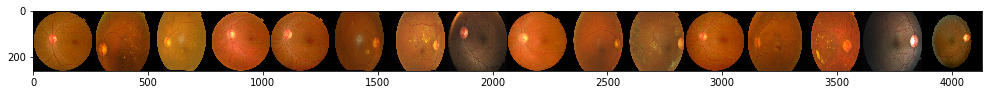

In [52]:
traindataset = RetinopathyDatasetTrain('train.csv')
trainloader = DataLoader(traindataset, shuffle = True, batch_size = 16)
batch = next(iter(trainloader))
showbatch(batch, (17,17))

Is data balanced ? 

In [ ]:
numclas0 = (traindataset.data.values[:,1] == 0).sum()
numclas1 = (traindataset.data.values[:,1] == 1).sum()
numclas2 = (traindataset.data.values[:,1] == 2).sum()
numclas3 = (traindataset.data.values[:,1] == 3).sum()
numclas4 = (traindataset.data.values[:,1] == 4).sum()
print(f" Number of class 0 is : {numclas0}")
print(f" Number of class 1 is : {numclas1}")
print(f" Number of class 2 is : {numclas2}")
print(f" Number of class 3 is : {numclas3}")
print(f" Number of class 4 is : {numclas4}")

Data is unbalanced, needs DataAugmentation

# Model


In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)
        
        self.fc1 = nn.Linear(in_features=12 * 61 * 61, out_features=500)
        self.fc2 = nn.Linear(in_features=500, out_features=125)
        self.fc3 = nn.Linear(in_features=125, out_features=60)
        self.out = nn.Linear(in_features=60, out_features=5)
        
    def forward(self, t):
        
        # first layer
        
        t = self.conv1(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)
        
        # second layer

        t = self.conv2(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)
        
        # third layer

        t = t.reshape(-1, 12 * 61 * 61)   
        t = self.fc1(t)
        t = F.relu(t)
        
        # fourth layer
        
        t = self.fc2(t)
        t = F.relu(t)
        
        # fifth layer
        
        t = self.fc3(t)
        t = F.relu(t)
        
        # sixth layer
                
        t = self.out(t)
        
        
        return t


# Score

In [ ]:
def kappascore(label, output):
    predlabel = output.argmax(dim = 1)
    truelabel = label
    loss = cohen_kappa_score(predlabel, truelabel, weights = 'quadratic')
    #print(f" predicted labels : {predlabel}")
    #print(f" true labels : {truelabel}")

    return loss


# Learning


In [ ]:
def getnumcorr(preds, label):
    predlabel = preds.argmax(dim = 1)
    return (predlabel==label).sum()

In [ ]:
net = Net()
optimizer = optim.Adam(net.parameters(), lr = 0.01)
for epoch in range(2):
    total_loss = 0.0
    total_correct = 0
    for batch in trainloader:      
        image = batch['image']
        label = batch['label']
        preds = net(image)
        
        loss = F.cross_entropy(preds, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        total_correct += getnumcorr(preds, label)
    print(f"epoch {epoch},  : total loss : {total_loss}, correct guesses : {total_correct}")
    print(f"accuracy score: {float(total_correct) / len(traindataset)}")

In [ ]:
def getpreds(net, loader):
    i = 0
    preds = torch.empty(len(loader.dataset))
    for batch in loader:
        image = batch['image']
        pred = net(image)
        pred = pred.argmax(dim = 1)
        preds[loader.batch_size * i : pred.shape[0]*(i + 1)] = pred
        i = i + 1
    return preds
        

In [ ]:
with torch.no_grad():
    preds = getpreds(net, trainloader)
    